# OMR Music Sheet to A MP3 file


In [1]:
import skimage.io as io
from skimage import img_as_ubyte
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.exposure import histogram
from skimage.filters import threshold_otsu,threshold_local,median, unsharp_mask
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv
from commonfunctions import *
from scipy.ndimage import rotate
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, skeletonize, thin, binary_opening, remove_small_objects
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.transform import resize


In [2]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


In [3]:
def histogram_equation(image):
    shape=image.shape
    H=np.zeros(256)
    for x in range(0,shape[0]):
        for y in range(0,shape[1]):
            H[image[x][y]]+=1

    return H


def getThresholdRawan(img):
    counts, _ = np.histogram(img, bins=256, range=(0, 256))
    
    total_pixels = np.sum(counts)
    print(total_pixels)
    Tinit = int(round(np.sum([i * counts[i] for i in range(256)]) / total_pixels))

    
    while True:
        if np.sum(counts[:Tinit]) == 0 or np.sum(counts[Tinit:]) == 0:
            return Tinit
        lower = np.sum([i * counts[i] for i in range(Tinit)]) / np.sum(counts[:Tinit])
        higher = np.sum([i * counts[i] for i in range(Tinit, 256)]) / np.sum(counts[Tinit:])
        new_T = int((lower + higher) / 2)
        if new_T == Tinit:
            return new_T
        Tinit = new_T

def partition_imageRawan(img, n_partitions_horiz, n_partitions_vert):
    print(img.shape)
    height, width = img.shape
    row_step = height // n_partitions_horiz
    col_step = width // n_partitions_vert
    
    binary_img = np.zeros_like(img)
    
    for i in range(n_partitions_horiz):
        for j in range(n_partitions_vert):
            row_start = i * row_step
            row_end = (i + 1) * row_step if i < n_partitions_horiz - 1 else height
            col_start = j * col_step
            col_end = (j + 1) * col_step if j < n_partitions_vert - 1 else width
            
            img_section = img[row_start:row_end, col_start:col_end]
            threshold = getThresholdRawan(img_section)
            binary_section = img_section > threshold
            binary_img[row_start:row_end, col_start:col_end] = binary_section
            
    return binary_img


In [4]:
def getThreshold(image):
    # image = (image * 255).astype('uint8')

    counts, _ = np.histogram(image, bins=256, range=(0, 256))
    
    total_pixels = counts.sum()
    gray_levels = np.arange(256)
    Tinit = round((gray_levels * counts).sum() / total_pixels) 
    
    while True:
        lower_pixels = counts[:Tinit]
        upper_pixels = counts[Tinit:]
        
        if lower_pixels.sum() == 0 or upper_pixels.sum() == 0:
            break

        lower_mean = (gray_levels[:Tinit] * lower_pixels).sum() / lower_pixels.sum()
        upper_mean = (gray_levels[Tinit:] * upper_pixels).sum() / upper_pixels.sum()

        new_threshold = round((lower_mean + upper_mean) / 2)
        
        if new_threshold == Tinit:
            break
        
        Tinit = new_threshold
    
    binary_image = np.where(image < Tinit, 0, 255) # 0 is black, 255 is white
    return binary_image


def adaptive (image, NumberOfDivisions):
    new_image = np.array_split(image, NumberOfDivisions, axis=1)
    thresholded_images = []
    for imagee in new_image:
        threshold = getThreshold(imagee)
        thresholded_images.append(threshold)    
    
    combined_image = np.block(thresholded_images)

    return combined_image

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


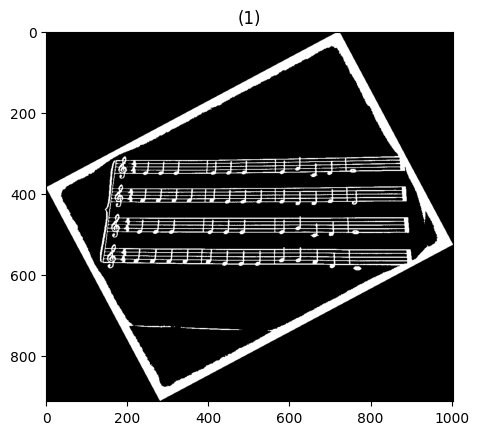

In [5]:
#Testing
def deskew(original_img):
    img = np.copy((original_img))
    # Canny
    imgCanny = sk.feature.canny(img, sigma=1.5)
    thresh = sk.filters.threshold_otsu(imgCanny)
    imgCanny = (imgCanny >= thresh)

    # Apply Hough Transform
    # Generates a list of 360 Radian degrees (-pi/2, pi/2)
    angleSet = np.linspace(-np.pi, np.pi, 1440)
    houghArr, theta, dis = sk.transform.hough_line(imgCanny, angleSet)

    flatIdx = np.argmax(houghArr)
    bestTheta = (flatIdx % theta.shape[0])
    bestTheta = angleSet[bestTheta]
    bestDis = np.int32(np.floor(flatIdx / theta.shape[0]))
    bestDis = dis[bestDis]

    # Rotate
    thetaRotateDeg = (bestTheta*180)/np.pi
    if thetaRotateDeg > 0:
        thetaRotateDeg = thetaRotateDeg - 90
    else:
        thetaRotateDeg = thetaRotateDeg + 90

    imgRotated = (sk.transform.rotate(
        img, thetaRotateDeg, resize=True, mode='constant', cval=1))
    return imgRotated

def binarize(img, block_size=101):
    t = sk.filters.threshold_local(img, block_size, offset=10)
    img_b = img < t
    return img_b



def convertImgToUINT8(img_o):
    img = np.copy(img_o)
    img = img.astype(np.float64) / np.max(img)
    img = 255 * img
    img = img.astype(np.uint8)
    return img



img = io.imread("./images/image2.png",as_gray=True)
if img.shape[0] > 1000 or img.shape[1] > 2000:
        img = sk.transform.resize(img, (img.shape[0]//4, img.shape[1]//4))
img1=deskew(img)
img2 = convertImgToUINT8(img1)
img3=binarize(img2)
show_images([img3])

(786, 620)


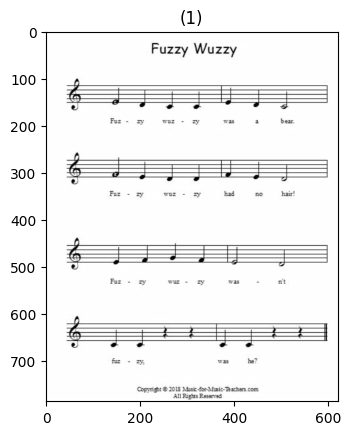

In [6]:
img = io.imread("./images/image.png",as_gray=True)
print(img.shape)
# 1. Binarization

# # Compute Otsu's threshold
# otsu_threshold = threshold_otsu(img)
# binary_image_ski = img > otsu_threshold

#Adaptive ski
# # Compute a local threshold
# block_size = 201  # Size of the local region to consider
# local_thresh = threshold_local(img, block_size, offset=0)

#our threshold
# print(img)
# threshold=getThreshold(img)
# img[img>threshold]=1
# img[img<=threshold]=0

show_images([img])

In [7]:
def dynamic_binarization(input_image):
    # Calculate the histogram of the input image
    hist = cv2.calcHist([input_image], [0], None, [256], [0, 256])
    # Normalize the histogram for easier analysis
    normalized_hist = hist / hist.sum()
    
    # Check if the histogram has significant peaks near 0 and 255
    near_zero = normalized_hist[:20].sum()  # Sum of bins near 0
    near_255 = normalized_hist[-20:].sum()  # Sum of bins near 255

    # Thresholds for determining scanned images
    if near_zero+near_255 > 0.75:
        # Use Otsu's binarization for scanned images
        _, binarized_image = cv2.threshold(input_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    else:
        # Apply both Otsu and Adaptive Thresholding
        _, otsu_binary = cv2.threshold(input_image, 0, 255,cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
        adaptive_binary = cv2.adaptiveThreshold(input_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                cv2.THRESH_BINARY, blockSize=9, C=5)
        
        # Calculate the number of black pixels for Otsu's output
        otsu_black_pixels = np.sum(otsu_binary == 0)

        # Threshold for deciding noise
        noise_threshold = np.sum(hist[:120])

        if otsu_black_pixels > noise_threshold:
            # Otsu produces noise, use Adaptive Thresholding
            binarized_image = adaptive_binary
        else:
            # Otsu works fine
            binarized_image = otsu_binary

    return binarized_image

In [8]:

def resize_with_aspect_ratio(image, target_width, target_height, color=0):
    # Get original dimensions
    h, w = image.shape[:2]
    
    # Calculate the scaling factor to maintain aspect ratio
    scale = min(target_width / w, target_height / h)
    
    # Compute the new dimensions
    new_width = int(w * scale)
    new_height = int(h * scale)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Create a new blank image with the target dimensions
    canvas =np.full((target_height, target_width), color, dtype=np.uint8)
    
    # Calculate padding to center the resized image
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    
    # Place the resized image onto the canvas
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_image
    
    return canvas


Rotating by 2.62 degrees


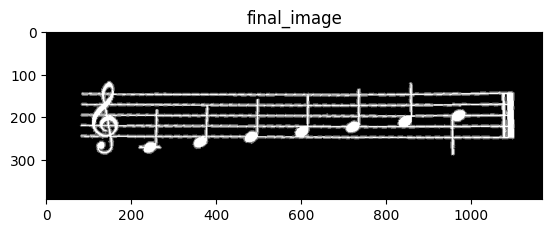

In [92]:
# Read the image
img = cv2.imread("./images/image11.png")

#remove noise using ski and opencv filters
# remove_noise = median(img)
remove_noise = cv2.bilateralFilter(img, 3, 75, 75)

# show_images([remove_noise])

# Convert to grayscale
gray = cv2.cvtColor(remove_noise, cv2.COLOR_BGR2GRAY)

#dynamic_binarization to apply any of otsu or adaptive
binarized_image=dynamic_binarization(gray)

# show_images([binarized_image],["binarized_image"])

edges = cv2.Canny(gray, 50, 150)

#detect lines using Hough Transform
lines = cv2.HoughLines(edges, 1, np.pi / 180.0, 250, np.array([]))

rotated_image=binarized_image

if lines is not None:  # Found lines
    angles = []  # Store the angles of the detected lines
    zero_angle_count = 0  # Count lines with angles close to 0°
    tolerance_zero = 2.0  # Tolerance to consider an angle as 0° (degrees)

    for line in lines:
        rho, theta = line[0]
        # Convert polar coordinates to Cartesian line endpoints
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))  # Endpoint 1
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))  # Endpoint 2
        y2 = int(y0 - 1000 * (a))

        # # Draw the line on the output image
        # cv2.line(output_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red line with thickness 2

        # Convert angle to degrees
        angle_degrees = 180 * theta / np.pi
        angles.append(angle_degrees)

        # Check if angle is close to 0° (horizontal line)
        if abs(angle_degrees) < tolerance_zero or abs(angle_degrees - 180) < tolerance_zero:
            zero_angle_count += 1

    # Majority Check: If most lines are at zero angles, skip rotation
    if zero_angle_count > len(angles) / 2:  # Majority condition
        print("Majority of lines are horizontal. Skipping rotation.")
    else:
        # Calculate the average angle excluding near-zero angles
        average_angle = np.mean([angle for angle in angles if abs(angle) > tolerance_zero])
        if(average_angle - 90)>2:
            print(f"Rotating by {average_angle - 90:.2f} degrees")
            rotated_image = rotate(rotated_image, average_angle - 90, cval=255)

else:
    print("No lines found")


rotated_image=255-rotated_image
rotated_image=rotated_image>0
final_image=remove_small_objects(rotated_image, 700, connectivity=8)

show_images([final_image],["final_image"])



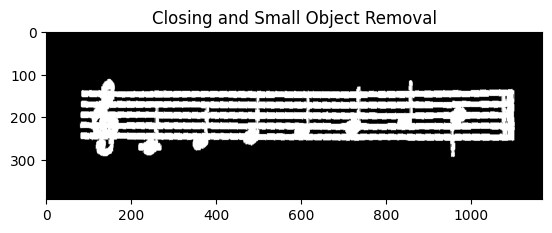

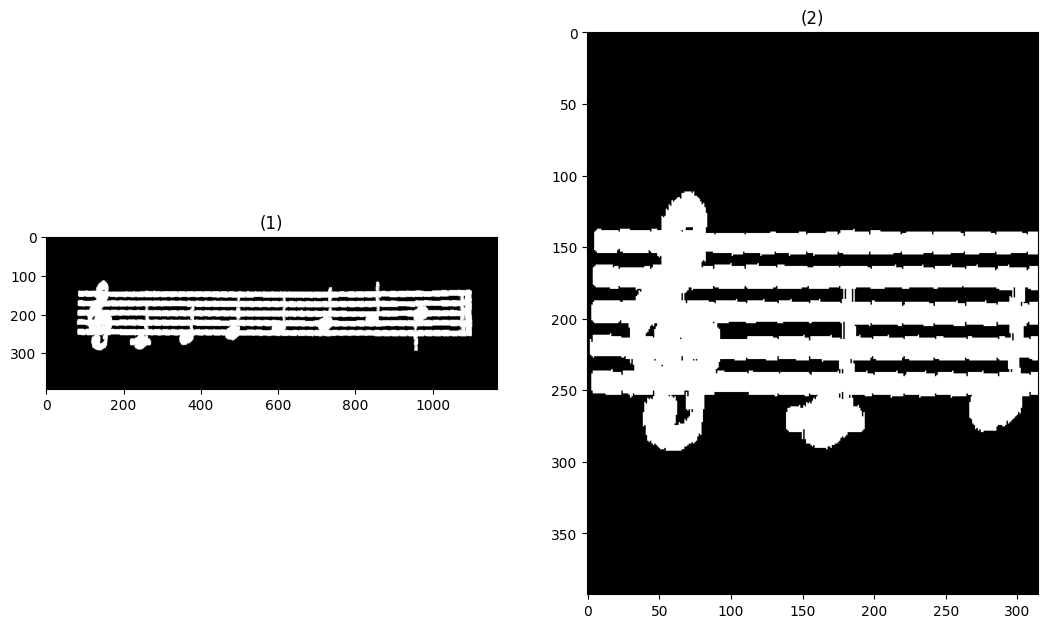

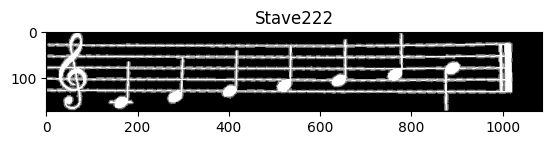

In [93]:
# Function to detect bounding boxes for staves

def getBoundedBoxes(image):
    #get staff bounding boxes whether they are connected or not
    img_height=image.shape[0]
    img_width=image.shape[1]

    dilation = binary_dilation(image, footprint=np.ones((10, 1)))
    # show_images([dilation], ['Dilation'])

    closing = remove_small_objects(dilation, 200, connectivity=8)
    show_images([closing], ['Closing and Small Object Removal'])


    img_without_begin=closing[:,int(img_height*0.2):img_height]
    show_images([closing,img_without_begin])

    img_without_begin = (img_without_begin * 255).astype('uint8')
    output_image = (image * 255).astype('uint8')


    contours_without_begin, _ = cv2.findContours(img_without_begin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_with_begin, _ = cv2.findContours(output_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_without_begin = cv2.cvtColor(img_without_begin, cv2.COLOR_GRAY2BGR)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2BGR)

    #check if they are connected in the begining
    staves=[]
    correct_countours=contours_with_begin
    is_correct_contours=False

    if len(contours_with_begin) != len(contours_without_begin):
        is_correct_contours=True
        correct_countours=contours_without_begin
        
    for contour in correct_countours:
        x, y, w, h = cv2.boundingRect(contour)
        # cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        if(w>1.1*h and w*h > 50):
            start_x = x
            end_x = img_width
            # print("width",img_width)
            # print("final_image shape",image.shape)
            if(is_correct_contours):
                start_x=0
            stave = output_image[y:y + h, start_x:end_x]
            # print("Width",w)
            # print("Height",h)
            staves.append(stave)
            show_images([stave], ["Stave222"])

    return staves

staves2= getBoundedBoxes(final_image)


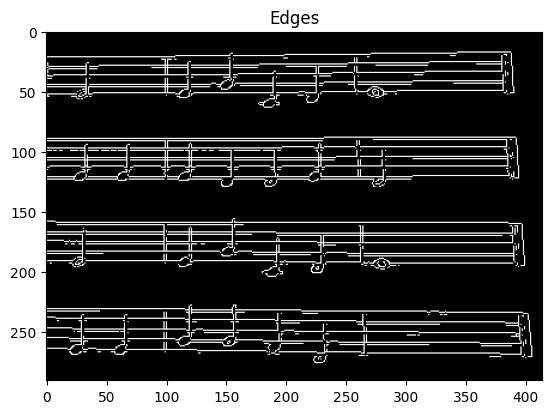

Stave ratio: 1.422680412371134


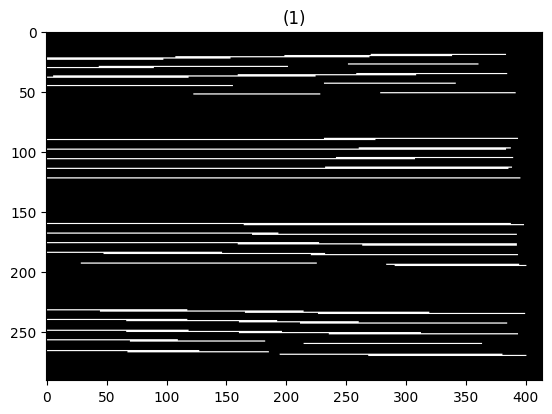

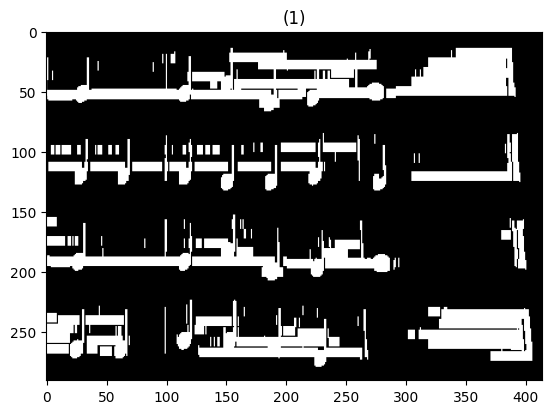

[[18, 27, 34, 41, 49]]


In [12]:
def remove_staff_lines(staves):
    cleaned_staves = []
    staff_lines_positions = []

    for stave in staves:
        # Invert stave to make lines white on black background
        stave = 255 - stave
        
        # Edge detection for the stave
        edges = cv2.Canny(stave, 50, 150, apertureSize=3)
        show_images([edges], ['Edges'])

        # Detect lines using Hough Transform
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
        
        if lines is not None:
            line_y_positions = []
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if abs(y2 - y1) < 5:  # Ensure the line is horizontal
                    line_y_positions.append((y1 + y2) // 2)  # Average y-coordinate for the line

            # Get 5 staff line positions by finding the most frequent y-coordinates
            line_y_positions = sorted(line_y_positions)
            staff_lines = []
            for y in line_y_positions:
                if not staff_lines or abs(y - staff_lines[-1]) > 5:  # Avoid duplicates
                    staff_lines.append(y)
            staff_lines_positions.append(staff_lines[:5])  # Ensure only 5 lines are kept
        else:
            staff_lines_positions.append([])  # No lines detected

        stave_ratio = stave.shape[1]/stave.shape[0]
        print("Stave ratio: "+str(stave_ratio))


        # Remove the detected staff lines from the stave image
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1)) # x value of MORPH_RECT range [15-100] it depend on the zoom in of ------>
        detected_lines = cv2.morphologyEx(stave, cv2.MORPH_OPEN, horizontal_kernel)
        
        show_images([detected_lines])

        cleaned_image = stave - detected_lines
        cleaned_image = cleaned_image > 0
        dilated = binary_dilation(cleaned_image, footprint=np.ones((8, 1))) # 1st dilation depeneds on the zoom in , range [2-7] ------>

        cleaned_staves.append(dilated)
        # show_images([dilated], ['Cleaned Stave'])

    return cleaned_staves, staff_lines_positions

cleaned_staves, staff_lines_positions = remove_staff_lines(staves)
show_images(cleaned_staves)
print(staff_lines_positions)

In [13]:

def detect_notes(cleaned_stave, staff_lines):
    # Step 1: Remove staff lines
    # stave_no_lines = cleaned_stave.copy()
    # for line in staff_lines:
    #     stave_no_lines[line - 2:line + 2, :] = 0  # Mask out staff lines (2-pixel width)
    # Step 2: Use morphological operations to isolate note heads

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25)) # it get affected by the zoom in factor,range [(3,3) - (20,20)] ------> 
    processed_stave = cv2.morphologyEx(cleaned_stave.astype('uint8') * 255, cv2.MORPH_CLOSE, kernel)
    processed_stave = cv2.morphologyEx(processed_stave.astype('uint8') * 255, cv2.MORPH_OPEN, kernel)

    # Optional: Edge detection to highlight contours
    edges = cv2.Canny((processed_stave * 255).astype('uint8'), 50, 150)
    show_images([edges], ['Edges'])

    # Step 3: Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    show_images([cv2.drawContours(processed_stave, contours, -1, (0, 255, 0), 2)], ['Contours'])

    contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])

    notes = []

    differences = [j - i for i, j in zip(staff_lines[:-1], staff_lines[1:])]
    average_distance_between_spaces = sum(differences) / len(differences)
    print("average dist: " + str(average_distance_between_spaces))
    
    staff_lines.append(staff_lines[-1]+int(average_distance_between_spaces))
    staff_lines.append(staff_lines[0]-int(average_distance_between_spaces))

    staff_lines = sorted(staff_lines)

    print(staff_lines)
    notes=[]
    for contour in contours:
        # Filter based on contour size (area) and aspect ratio
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h if h > 0 else 0

        factor = 12 # this factor is for the value of zoom in
        print("area: " + str(area) + ", aspect ratio: " + str(aspect_ratio))
        if (10 * factor) < area < (300 * factor) and 0.7 < aspect_ratio < 1.3:  # Typical note head properties  area varies with the zoom in, range [300] --------->
            note_center = y + h // 2  # Vertical center of the note head

            print("note center: " + str(note_center) + ",x= " + str(x) + ",y1= " + str(y) +",y2= " + str(y+h))

            note_names_treble = ['C','D','E','F','G','A','B','C2','D2','E2','F2','G2','A2','B2']
            y1=y + int(average_distance_between_spaces/ 8)
            y2=y+h - int(average_distance_between_spaces/ 8)

            if  y2>staff_lines[-1] and y1<staff_lines[-1]:
                notes.append('C')
            elif y2<=staff_lines[-1] and y1>=staff_lines[-2]:
                notes.append('D')
            elif y2>staff_lines[-2] and y1<staff_lines[-2]:
                notes.append('E')
            elif y2<=staff_lines[-2] and y1>=staff_lines[-3]:
                notes.append('F')
            elif y2>staff_lines[-3] and y1<staff_lines[-3]:
                notes.append('G')
            elif y2<=staff_lines[-3] and y1>=staff_lines[-4]:
                notes.append('A')
            elif y2>staff_lines[-4] and y1<staff_lines[-4]:
                notes.append('B')
            elif y2<=staff_lines[-4] and y1>=staff_lines[-5]:
                notes.append('C2')
            elif y2>staff_lines[-5] and y1<staff_lines[-5]:
                notes.append('D2')
            elif y2<=staff_lines[-5] and y1>=staff_lines[-6]:
                notes.append('E2')
            elif y2>staff_lines[-6] and y1<staff_lines[-6]:
                notes.append('F2')
            elif y2<=staff_lines[-6] and y1>=staff_lines[-7]:
                notes.append('A2')
            elif y2>staff_lines[-7] and y1<staff_lines[-7]:
                notes.append('B2')

    
    return notes


[[18, 27, 34, 41, 49]]


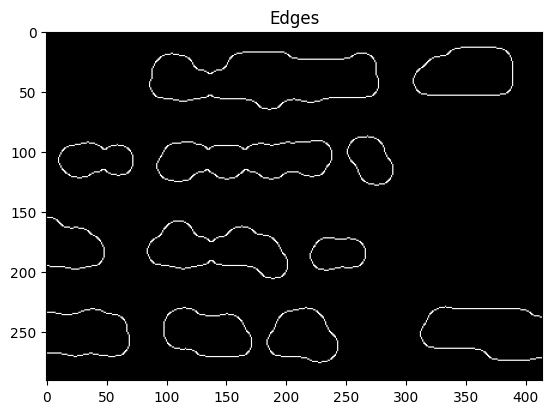

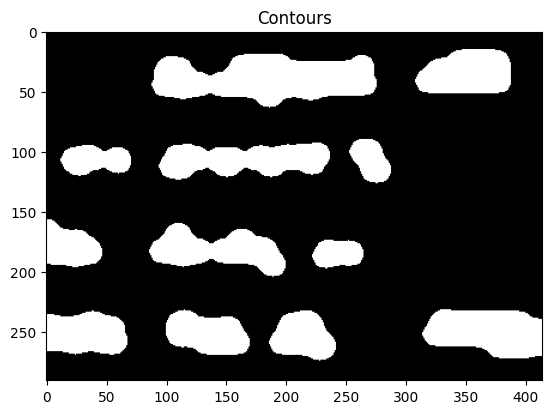

average dist: 7.75
[11, 18, 27, 34, 41, 49, 56]
area: 6.0, aspect ratio: 1.7073170731707317
area: 14.0, aspect ratio: 1.0888888888888888
area: 1404.5, aspect ratio: 2.032258064516129
area: 3316.0, aspect ratio: 2.4081632653061225
area: 6530.5, aspect ratio: 3.9183673469387754
area: 3722.5, aspect ratio: 4.2
area: 2280.0, aspect ratio: 1.7619047619047619
area: 1936.0, aspect ratio: 1.2765957446808511
note center: 253,x= 184,y1= 230,y2= 277
area: 1018.5, aspect ratio: 1.6785714285714286
area: 1082.5, aspect ratio: 0.9285714285714286
note center: 108,x= 251,y1= 87,y2= 129
area: 2832.0, aspect ratio: 2.048780487804878
area: 13.0, aspect ratio: 2.217391304347826
Detected Notes in Stave 1: []


In [14]:
# Function to map note positions to musical notes
def map_positions_to_notes(positions, clef='treble'):
    note_names_treble = ['F', 'E', 'D', 'C', 'B', 'A', 'G']
    note_names_bass = ['A', 'G', 'F', 'E', 'D', 'C', 'B']
    
    note_names = note_names_treble if clef == 'treble' else note_names_bass
    mapped_notes = [note_names[pos % len(note_names)] for pos in positions if pos >= 0]
    return mapped_notes

# Main processing
# final_image = cv2.imread('sheet_music.png', cv2.IMREAD_GRAYSCALE)  # Load your image here
# final_image = final_image < 128  # Binarize the image
# show_images([final_image], ["Final Image"])

# staves = getBoundedBoxes(final_image)
# cleaned_staves, staff_lines_positions = remove_staff_lines(staves)

print(staff_lines_positions)

for i, (stave, staff_lines) in enumerate(zip(cleaned_staves, staff_lines_positions)):
    notes = detect_notes(stave, staff_lines)
    print(f"Detected Notes in Stave {i + 1}: {notes}")
